In [1]:
# Use warpx_env as kernal
import numpy as np
import h5py
import matplotlib.colors as colors
import scipy
import matplotlib.pyplot as plt
import scipy.constants as cons
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.gridspec as gridspec
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from openpmd_viewer import ParticleTracker

def add_colorbar(im, width = None, pad = None, **kwargs):
    l, b, w, h = im.axes.get_position().bounds  # get boundaries
    width = width or 0.05*w                    # width of colorbar
    pad = pad or width                         # pad between im and cbar
    fig = im.axes.figure                       # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h]) # define cbar axes
    return fig.colorbar(im,cax=cax,**kwargs)
#######################constants#####################

qe = cons.elementary_charge
me = cons.electron_mass
epsilon0 = cons.epsilon_0
clight = cons.speed_of_light
pi = cons.pi

### We are looking at a 1D laser field propagating in free space. The solver that we are using is called the Finite Difference Time Domain (FDTD) solver. It is a method of solving Maxwell's equations. The solver following whats called the Courant condition which states that in order for a simulation to be stable:

# $$ c \Delta t \leq 1 / (\Delta x^{-2} + \Delta z^{-2}) $$

### where c is the speed of light, $\Delta t$ is the time step and $\Delta x$ is the spatial step. A light wave must not travel farther than one spatial cell in a single time step.

In [10]:
# laser_plasma parameters
lam = 800e-9
dens = 0.002
a0 = 2
x_dom = 50e-6
z_dom = 100e-6
x_cells = 1024
z_cells = 2048

dx = x_dom/x_cells
dz = z_dom/z_cells

cells_per_lam_x = lam/dx
cells_per_lam_z = lam/dz

dt = (1 / (dx**-2 + dz**-2)**(1/2))/clight


print("Delta x = {}".format(dx))
print("Delta z = {}".format(dz))
print("Wavelengths per cell in x = {}".format(cells_per_lam_x))
print("Wavelengths per cell in z = {}".format(cells_per_lam_z))
print("Delta t = {}".format(dt))

Delta x = 4.8828125e-08
Delta z = 4.8828125e-08
Wavelengths per cell in x = 16.383999999999997
Wavelengths per cell in z = 16.383999999999997
Delta t = 1.1516866878660566e-16


# Load data with OpenPMDTimeSeries and LpaDiagnostics

### LpaDiagnostics provides tools check laser and plasma conditions such as the pulse duration and laser waist. 

In [17]:
path_2D ='/Users/victorflores/warpx_env/WarpX/Laser_2D/diags/diag1'
lpa_data = LpaDiagnostics("{}".format(path_2D),backend="h5py")
data= OpenPMDTimeSeries("{}".format(path_2D),backend="h5py")

In [18]:
len(data.iterations)

15

In [31]:
j = 4
t=data.t[j]
Ey, Ey_info = data.get_field(t=data.t[j], field='E',coord="y", plot=False)
Ey_slice, Ey_info_slice = data.get_field(t=data.t[j], field='E',coord="y", plot=False, slice_across="x",slice_relative_position= 0)
norm = (2*pi*me*clight**2) / (qe*lam)
Ey_norm = Ey/norm
Ey_slice_norm = Ey_slice / norm
Z = Ey_info.z
X = Ey_info.x

# Lets take a look at the laser field 

### scan through each iteration, what do you notice?

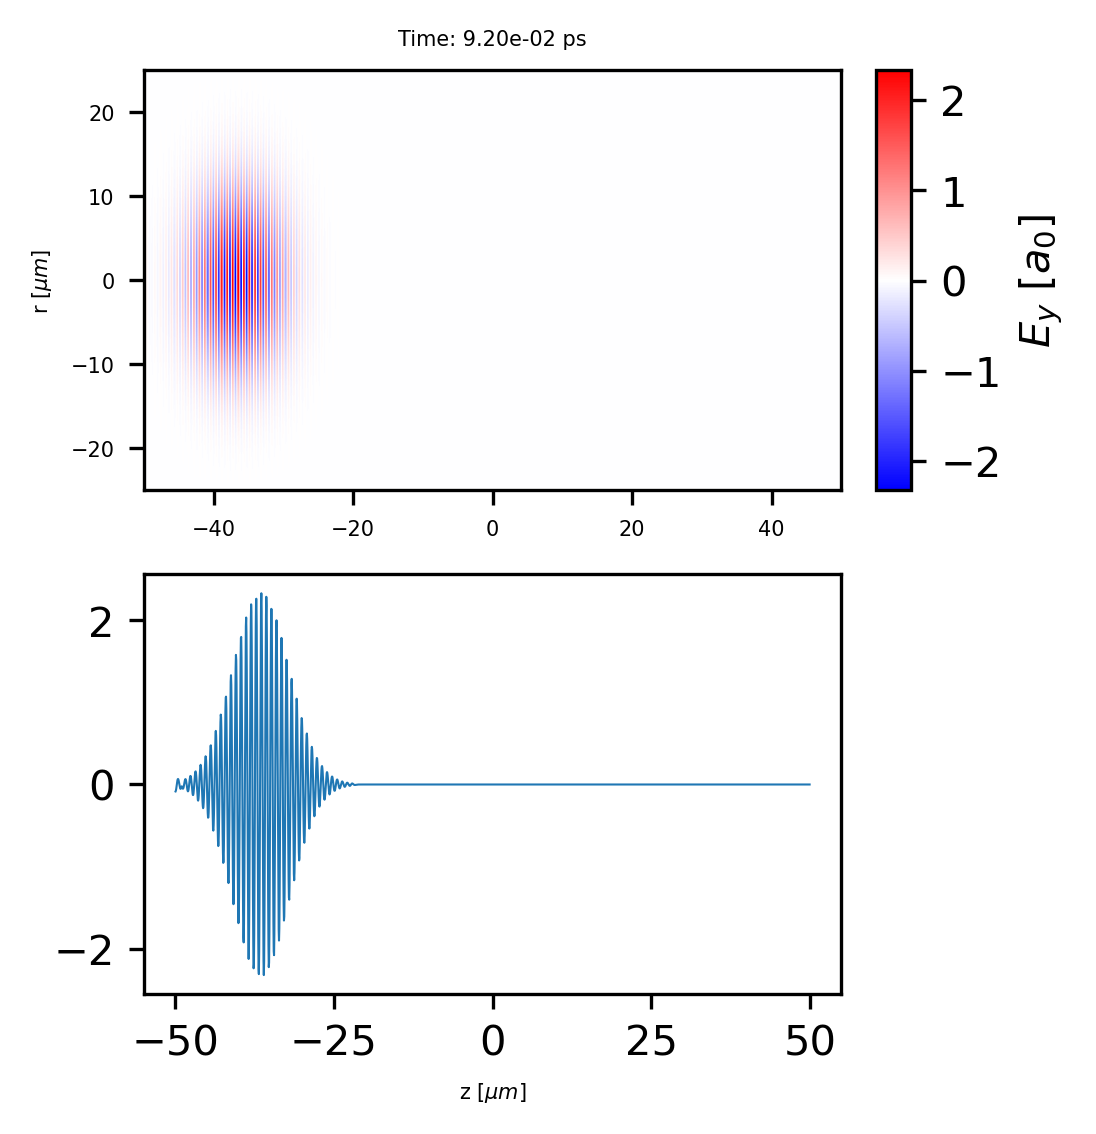

In [ ]:
fig_width = 3 
fig_height = 2  
fig, ax = plt.subplots(2,1,figsize=(fig_width, 2*fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
Ey_field = ax[0].pcolormesh(Z *10**6, X*10**6, Ey_norm.T, cmap='bwr')
cb1 = add_colorbar(Ey_field)
cb1.set_label('$E_y$ [$a_0$]')
ax[0].set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax[0].tick_params('x',labelsize=5)
ax[0].tick_params('y',labelsize=5)
ax[0].set_ylabel(r'r [$\mu m$]', fontsize = 5)

ax[1].plot(Z*10**6 , Ey_slice_norm, linewidth = 0.5)

ax[1].set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

# Use LpaDiagnostics to see how the laser waist is evolving in time. 

### Physically what does this mean ?

In [38]:
sim_times = data.iterations[4:]
waist = []
for i in sim_times:
    w0 = lpa_data.get_laser_waist(iteration=i, pol='y')
    waist.append(w0)

/Users/victorflores/opt/anaconda3/envs/warpx_env/lib/python3.12/site-packages/openpmd_viewer/addons/pic/lpa_diagnostics.py:982: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit( gaussian_profile, trans_pos,


Text(0, 0.5, '$w_0 [\\mu m]$')

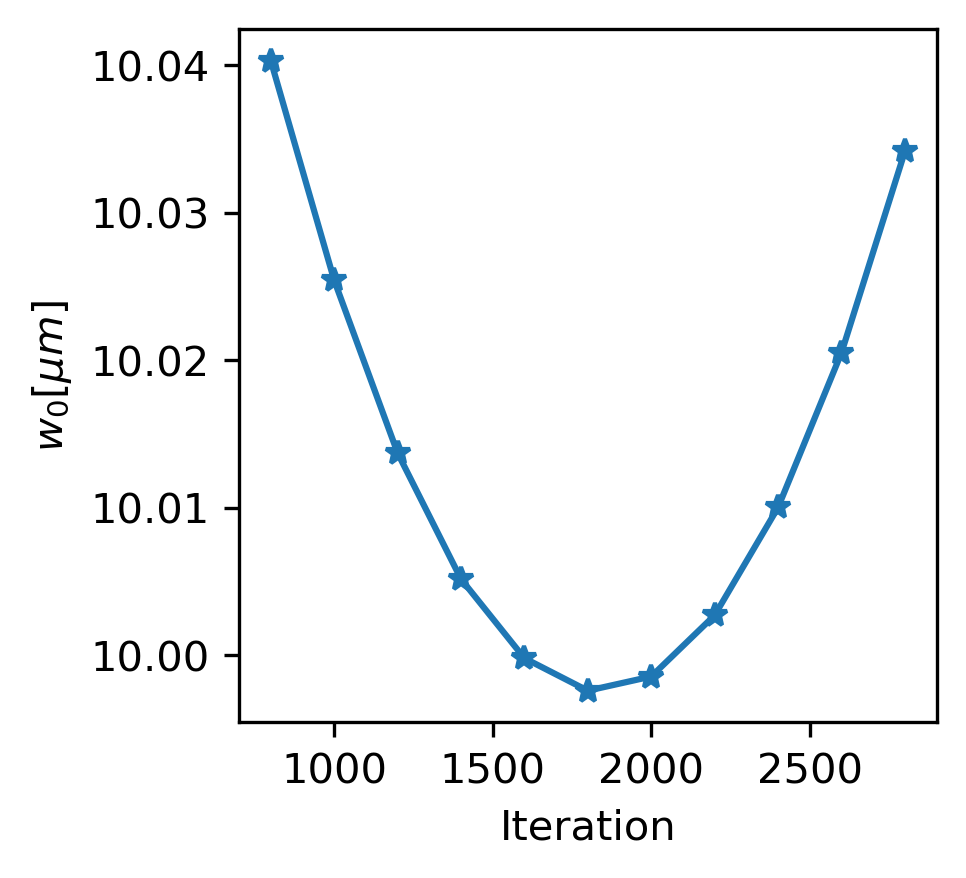

In [39]:
waist_arr = np.array(waist)
fig_width = 3 # Set width to 1.5 inches
fig_height = 3  # Set height to 1.5 inches
fig, ax = plt.subplots(1,1,figsize=(fig_width, 1*fig_height), dpi=300)
ax.plot(sim_times,waist_arr*10**6,"-*")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$w_0 [\mu m]$")